# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, <b>TreasureMaze.py</b>, represents the environment, which includes a maze object defined as a matrix. The second class, <b>GameExperience.py</b>, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation in the qtrain() function for which a skeleton implementation has been provided. 

The code block you will need to complete has <b>#TODO</b> as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

<div class="alert alert-block alert-warning" style="color: #333333;">
<b>Installations</b> The following command will install the necessary Python libraries to necessary to run this application. If you see a "[notice] A new release of pip is available: 23.1.2 -> 25.2" at the end of the installation, you may disregard that statement. 
</div>

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


<h2>Tensorflow CPU Acceleration Warning</h2>
<div class="alert alert-block alert-danger" style="color: #333333;">
    You will see a <b>warning in red</b> "oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders". This is simply coming from <b>Tensorflow to accelerate computations on CPU.</b>  
</div>

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import clone_model
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

2025-10-17 14:23:00.736060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 14:23:00.777903: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-17 14:23:01.281386: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-17 14:23:01.377437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760710981.582739     235 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760710981.61

<h2> Maze Object Generation</h2>

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

<h2>Helper Functions and Global Variables</h2>

This <b>show()</b> helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The <b>pirate agent</b> can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is the EXPLORATION values from the Cartpole assignment. The hyperparameters are provided here and used in the qtrain() method. 
You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
patience = 10

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


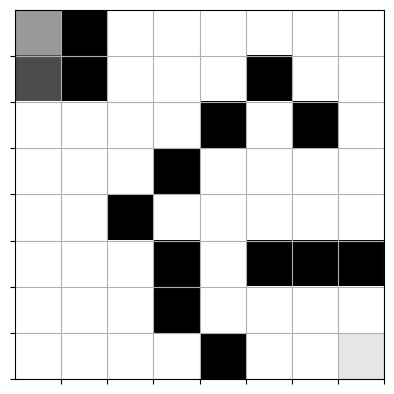

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This <b>play_game()</b> function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object, the starting position of the pirate and max amount of steps to make sure the code does not get stuck in a loop.

In [7]:
def play_game(model, qmaze, pirate_cell, max_steps=None):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    steps = 0
    if max_steps is None:
        max_steps = qmaze.maze.size * 4  # safety cutoff

    while steps < max_steps:
        state = np.asarray(envstate, dtype=np.float32)
        if state.ndim == 1:
            state = np.expand_dims(state, axis=0)

        q_values = model(state, training=False).numpy()
        action = np.argmax(q_values[0])

        envstate, reward, game_status = qmaze.act(action)
        steps += 1

        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

    return False  # timed out with no result

This <b>completion_check()</b> function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, maze_or_qmaze, max_steps=None):
    # Accept either raw numpy maze or TreasureMaze instance
    if isinstance(maze_or_qmaze, TreasureMaze):
        qmaze = maze_or_qmaze
    else:
        qmaze = TreasureMaze(maze_or_qmaze)

    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            continue
        if not play_game(model, qmaze, cell, max_steps=max_steps):
            return False
    return True

The <b>build_model()</b> function in the block below will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

This <b>train_step()</b> helper function in the block below is used to help predict Q-values (quality values) in the current modelto see how good each action is in a given state and improve the Q-network by reducing the gap between what is predicted and what should have been predicted. 

If you're interested in reading up on the <i>@tf.function</i>, which is a decorator for Tensorflow to run this code into a TensorFlow computation graph, please refer to this link: https://www.tensorflow.org/guide/intro_to_graphs



<h2>Tensorflow GPU Warning</h2>
<div class="alert alert-block alert-danger" style="color: #333333;">
    You will see a <b>warning in red</b> "INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.". This is simply coming from <b>Tensorflow skipping using GPU for this assignment.</b>  
 </div>

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        q_values = model(x, training=True)
        loss = loss_fn(y, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

E0000 00:00:1760711010.734932     235 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1760711010.739520     235 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

    Pseudocode:
    For each epoch:
        Reset the environment at a random starting cell
        agent_cell = randomly select a free cell
        Hint: Review the reset method in the TreasureMaze.py class.
    
        Set the initial environment state
        env_state should reference the environment's current state
        Hint: Review the observe method in the TreasureMaze.py class.

        While game status is not game over:
           previous_envstate = env_state
            Decide on an action:
                - If possible, take a random valid exploration action and 
                  randomly choose action (left, right, up, down)
                  and assign it to an action variable
                - Else, pick the best exploitation action from the model and assign it to an action variable
                  Hint: Review the predict method in the GameExperience.py class.
    
           Retrieve the values below from the act() method.
           env_state, reward, game_status = qmaze.act(action)
           Hint: Review the act method in the TreasureMaze.py class.
    
            Track the wins and losses from the game_status using win_history 
         
           Store the episode below in the Experience replay object
           episode = [previous_envstate, action, reward, envstate, game_status]
           Hint: Review the remember method in the GameExperience.py class.
        
           Train neural network model and evaluate loss
           Hint: Call GameExperience.get_data to retrieve training data (input and target) 
           and pass to the train_step method and assign it to batch_loss and append to the loss variable
        
      If the win rate is above the threshold and your model passes the completion check, that would be your epoch.

Note: A 100% win rate <b>DOES NOT EXPLICITLY MEAN</b> that you have solved the maze. It simply indicates that during the last evaluation, the pirate <i>happened</i> to get to the treasure. Be sure to utilise the <b>completion_check()</b> function to validate your pirate found the treasure at every starting point and consistently! 

<b> You will need to complete the section starting with #START_HERE. Please use the pseudocode above as guidance. </b>




In [11]:
def qtrain(model, maze, **opt):
    """
    Train the pirate agent using deep Q-learning algorithm.
    
    Args:
        model: Neural network model for Q-value prediction
        maze: The maze environment (numpy array)
        **opt: Optional parameters including n_epoch, max_memory, data_size, target_update_freq
    
    Returns:
        Total training time
    """
    # Exploration factor (global variable)
    global epsilon 
    
    # Number of epochs - total training iterations
    n_epoch = opt.get('n_epoch', 15000)
    
    # Maximum memory to store episodes for experience replay
    max_memory = opt.get('max_memory', 1000)
    
    # Maximum data size for training batches
    data_size = opt.get('data_size', 50)
    
    # Frequency of target network updates (for stability)
    target_update_freq = opt.get('target_update_freq', 50)
    
    # Start time tracking
    start_time = datetime.datetime.now()
    
    # Construct environment/game from numpy array: maze
    qmaze = TreasureMaze(maze)
    
    # Create target network (helps stabilize training)
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())
    
    # Initialize experience replay object
    experience = GameExperience(model, target_model, max_memory=max_memory)

    # Track win/lose history
    win_history = []
    
    # History window size for calculating win rate
    hsize = qmaze.maze.size // 2
    
    # Initialize win rate
    win_rate = 0.0
    
    # ===== MAIN TRAINING LOOP =====
    for epoch in range(n_epoch):
        # Initialize loss and episode counter for this epoch
        loss = 0.0
        n_episodes = 0
        
        # Reset the environment at a random starting cell
        # Randomly select a free cell (not an obstacle) for the agent to start
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        
        # Set the initial environment state
        # Observe returns the current state of the environment
        envstate = qmaze.observe()
        
        # Initialize game_over flag
        game_over = False
        
        # ===== EPISODE LOOP (one game) =====
        while not game_over:
            # Store the previous environment state
            previous_envstate = envstate
            
            # Decide on an action: EXPLORATION vs EXPLOITATION
            if np.random.rand() < epsilon:
                # EXPLORATION: Randomly choose a valid action
                # This helps the agent discover new paths
                action = random.choice(qmaze.valid_actions())
            else:
                # EXPLOITATION: Use the model to predict best action
                # The agent uses what it has learned to choose the best action
                action = np.argmax(experience.predict(previous_envstate))
            
            # Execute the action and retrieve results
            # act() returns: new state, reward, game status
            envstate, reward, game_status = qmaze.act(action)
            
            # Track wins and losses from game_status
            if game_status == 'win':
                win_history.append(1)  # Record a win
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)  # Record a loss
                game_over = True
            else:
                game_over = False  # Game continues
            
            # Store the episode in Experience replay object
            # Episode contains: [previous state, action, reward, new state, status]
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            
            # Increment episode counter (number of steps in this game)
            n_episodes += 1
            
            # Train neural network model and evaluate loss
            # Get training data from experience replay (random batch)
            inputs, targets = experience.get_data(batch_size=data_size)
            
            # Convert to tensors for TensorFlow
            inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
            targets = tf.convert_to_tensor(targets, dtype=tf.float32)
            
            # Train using the custom train_step function
            batch_loss = train_step(inputs, targets)
            loss = batch_loss.numpy()
        
        # ===== POST-EPISODE UPDATES =====
        
        # Update target network periodically for training stability
        # Target network provides stable Q-value targets during training
        if epoch % target_update_freq == 0:
            target_model.set_weights(model.get_weights())
        
        # Calculate win rate over the last hsize games
        if len(win_history) >= hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        else:
            win_rate = sum(win_history) / len(win_history) if len(win_history) > 0 else 0.0
        
        # Print progress for this epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        
        # ===== EPSILON DECAY (Exploration vs Exploitation Balance) =====
        # As training progresses, reduce exploration and increase exploitation
        if win_rate > 0.9:
            epsilon = 0.05  # Minimal exploration when performance is high
        else:
            # Gradually decay epsilon but don't go below epsilon_min
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        # ===== CHECK FOR TRAINING COMPLETION =====
        # Training complete when win rate is very high AND agent can win from all positions
        if win_rate >= 0.999 and completion_check(model, qmaze):
            print(f"Reached 100% win rate at epoch {epoch}")
            break
    
    # Calculate and print total training time
    total_time = format_time((datetime.datetime.now() - start_time).total_seconds())
    print("Training complete in:", total_time)
    
    return (datetime.datetime.now() - start_time).total_seconds()


def format_time(seconds):
    """
    Format time in seconds to a readable string.
    
    Args:
        seconds: Time in seconds
    
    Returns:
        Formatted time string
    """
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an <b>instance</b> of TreasureMaze. This does not show your actual training done.

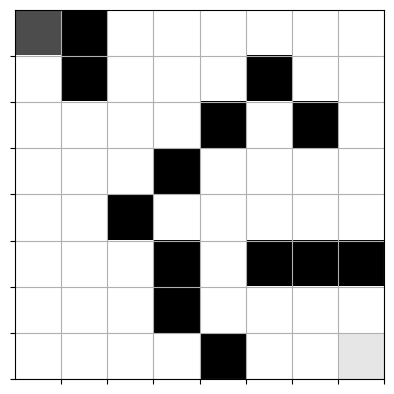

In [12]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model using the <b>build_model</b> function and train it using deep Q-learning. Note: This step takes several minutes to fully run.



<div class="alert alert-block alert-danger" style="color: #333333;">
    If you did not attempt the assignment, the code <b>will</b> error out at this section.
 </div>

In [13]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32, target_update_freq=50)

/home/codio/.pyenv/versions/3.11.2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 000/999 | Loss: 0.0015 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 3.7 seconds
Epoch: 001/999 | Loss: 0.0017 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 6.0 seconds
Epoch: 002/999 | Loss: 0.0022 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 8.3 seconds
Epoch: 003/999 | Loss: 0.0010 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 10.6 seconds
Epoch: 004/999 | Loss: 0.0011 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 12.9 seconds
Epoch: 005/999 | Loss: 0.0014 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 15.2 seconds
Epoch: 006/999 | Loss: 0.0019 | Episodes: 12 | Win count: 1 | Win rate: 0.143 | time: 15.4 seconds
Epoch: 007/999 | Loss: 0.0011 | Episodes: 145 | Win count: 1 | Win rate: 0.125 | time: 17.9 seconds
Epoch: 008/999 | Loss: 0.0017 | Episodes: 25 | Win count: 2 | Win rate: 0.222 | time: 18.4 seconds
Epoch: 009/999 | Loss: 0.0124 | Episodes: 149 | Win count: 2 | Win rate: 0.200 | time: 20.9 seconds
Epoch

Epoch: 082/999 | Loss: 0.0012 | Episodes: 142 | Win count: 29 | Win rate: 0.375 | time: 167.6 seconds
Epoch: 083/999 | Loss: 0.0009 | Episodes: 140 | Win count: 29 | Win rate: 0.375 | time: 170.1 seconds
Epoch: 084/999 | Loss: 0.0023 | Episodes: 149 | Win count: 29 | Win rate: 0.344 | time: 172.8 seconds
Epoch: 085/999 | Loss: 0.0020 | Episodes: 160 | Win count: 29 | Win rate: 0.312 | time: 175.5 seconds
Epoch: 086/999 | Loss: 0.0015 | Episodes: 151 | Win count: 29 | Win rate: 0.312 | time: 178.3 seconds
Epoch: 087/999 | Loss: 0.0010 | Episodes: 1 | Win count: 30 | Win rate: 0.312 | time: 178.3 seconds
Epoch: 088/999 | Loss: 0.0012 | Episodes: 144 | Win count: 30 | Win rate: 0.281 | time: 180.9 seconds
Epoch: 089/999 | Loss: 0.0016 | Episodes: 139 | Win count: 30 | Win rate: 0.281 | time: 183.5 seconds
Epoch: 090/999 | Loss: 0.0003 | Episodes: 142 | Win count: 30 | Win rate: 0.250 | time: 185.8 seconds
Epoch: 091/999 | Loss: 0.0007 | Episodes: 148 | Win count: 30 | Win rate: 0.250 | ti

Epoch: 163/999 | Loss: 0.0028 | Episodes: 51 | Win count: 65 | Win rate: 0.781 | time: 325.0 seconds
Epoch: 164/999 | Loss: 0.0026 | Episodes: 73 | Win count: 66 | Win rate: 0.812 | time: 326.5 seconds
Epoch: 165/999 | Loss: 0.0023 | Episodes: 10 | Win count: 67 | Win rate: 0.844 | time: 326.7 seconds
Epoch: 166/999 | Loss: 0.0018 | Episodes: 61 | Win count: 68 | Win rate: 0.844 | time: 327.9 seconds
Epoch: 167/999 | Loss: 0.0023 | Episodes: 94 | Win count: 69 | Win rate: 0.875 | time: 329.7 seconds
Epoch: 168/999 | Loss: 0.0023 | Episodes: 4 | Win count: 70 | Win rate: 0.875 | time: 329.7 seconds
Epoch: 169/999 | Loss: 0.0019 | Episodes: 157 | Win count: 71 | Win rate: 0.875 | time: 332.8 seconds
Epoch: 170/999 | Loss: 0.0022 | Episodes: 51 | Win count: 72 | Win rate: 0.875 | time: 333.9 seconds
Epoch: 171/999 | Loss: 0.0019 | Episodes: 3 | Win count: 73 | Win rate: 0.875 | time: 333.9 seconds
Epoch: 172/999 | Loss: 0.0021 | Episodes: 20 | Win count: 74 | Win rate: 0.875 | time: 334.3

Epoch: 245/999 | Loss: 0.0002 | Episodes: 23 | Win count: 145 | Win rate: 0.969 | time: 6.77 minutes
Epoch: 246/999 | Loss: 0.0011 | Episodes: 7 | Win count: 146 | Win rate: 0.969 | time: 6.78 minutes
Epoch: 247/999 | Loss: 0.0001 | Episodes: 134 | Win count: 146 | Win rate: 0.938 | time: 6.82 minutes
Epoch: 248/999 | Loss: 0.0001 | Episodes: 25 | Win count: 147 | Win rate: 0.938 | time: 6.84 minutes
Epoch: 249/999 | Loss: 0.0001 | Episodes: 9 | Win count: 148 | Win rate: 0.938 | time: 6.84 minutes
Epoch: 250/999 | Loss: 0.0001 | Episodes: 23 | Win count: 149 | Win rate: 0.938 | time: 6.85 minutes
Epoch: 251/999 | Loss: 0.0002 | Episodes: 1 | Win count: 150 | Win rate: 0.938 | time: 6.85 minutes
Epoch: 252/999 | Loss: 0.0002 | Episodes: 6 | Win count: 151 | Win rate: 0.938 | time: 6.85 minutes
Epoch: 253/999 | Loss: 0.0005 | Episodes: 24 | Win count: 152 | Win rate: 0.938 | time: 6.86 minutes
Epoch: 254/999 | Loss: 0.0002 | Episodes: 7 | Win count: 153 | Win rate: 0.938 | time: 6.86 mi

Epoch: 327/999 | Loss: 0.0007 | Episodes: 22 | Win count: 225 | Win rate: 0.969 | time: 8.00 minutes
Epoch: 328/999 | Loss: 0.0004 | Episodes: 29 | Win count: 226 | Win rate: 0.969 | time: 8.01 minutes
Epoch: 329/999 | Loss: 0.0004 | Episodes: 11 | Win count: 227 | Win rate: 0.969 | time: 8.02 minutes
Epoch: 330/999 | Loss: 0.0000 | Episodes: 29 | Win count: 228 | Win rate: 0.969 | time: 8.03 minutes
Epoch: 331/999 | Loss: 0.0001 | Episodes: 17 | Win count: 229 | Win rate: 0.969 | time: 8.03 minutes
Epoch: 332/999 | Loss: 0.0001 | Episodes: 29 | Win count: 230 | Win rate: 0.969 | time: 8.05 minutes
Epoch: 333/999 | Loss: 0.0003 | Episodes: 27 | Win count: 231 | Win rate: 0.969 | time: 8.06 minutes
Epoch: 334/999 | Loss: 0.0004 | Episodes: 3 | Win count: 232 | Win rate: 0.969 | time: 8.06 minutes
Epoch: 335/999 | Loss: 0.0005 | Episodes: 18 | Win count: 233 | Win rate: 0.969 | time: 8.07 minutes
Epoch: 336/999 | Loss: 0.0006 | Episodes: 20 | Win count: 234 | Win rate: 0.969 | time: 8.07

534.057219

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

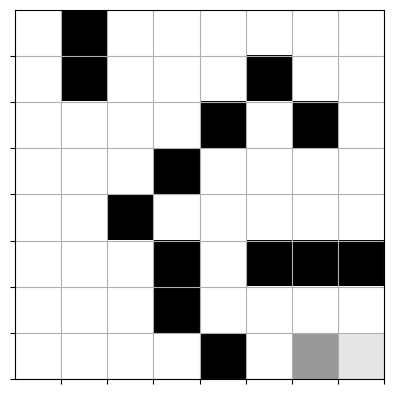

In [14]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run <b>play_game()</b>. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

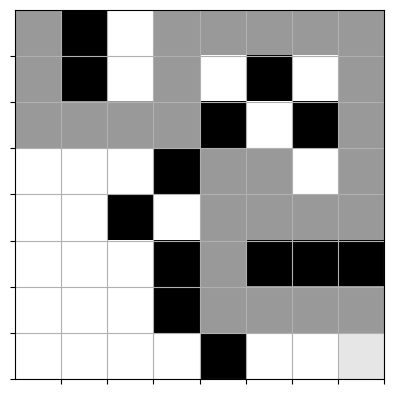

In [15]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.